# Imports

In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
from src import *

%autoreload 2

# Signal

In [11]:
dim = (32, 32)

# Sparse signal parameters
sparse_range = (-6, 6)
density = 0.005

# Smooth signal parameters
smooth_amplitude = 2
sigmas_range = (2e-2, 2e-1)
nb_gaussian = int(0.5 * dim[0])

# Seed
seed = 42

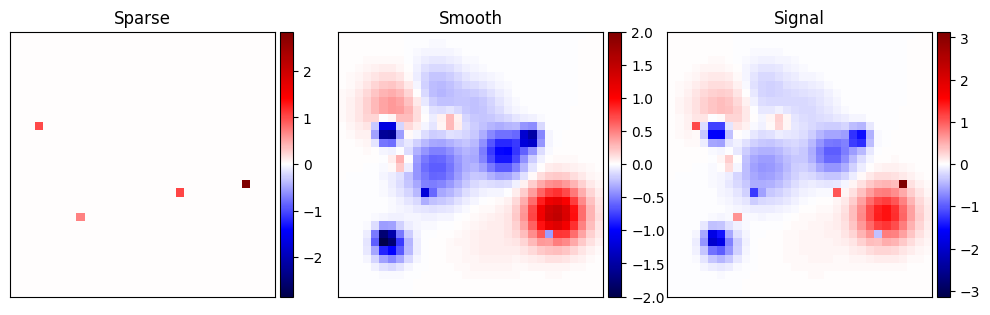

In [12]:
sparse_signal = compute_sparse(dim, sparse_range, density, seed)
smooth_signal = compute_smooth(dim, smooth_amplitude, sigmas_range, nb_gaussian, seed)

signal = sparse_signal + smooth_signal

plot_signal(sparse_signal, smooth_signal)

# Operator $\phi$

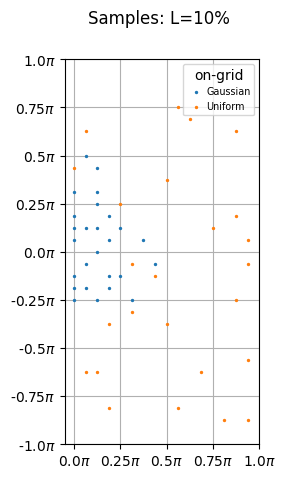

In [13]:
L = 0.1
theta = 0.5
op = NuFFT(dim, L, theta, on_grid=True, seed=seed)

x0 = signal.reshape(-1)
y0 = op(x0)

psnr = 50
y = compute_y(y0, psnr)

op.plot_samples()

# Solver

In [20]:
from pyxu.operator import Laplacian

# Loss weights
lambda1 = 1e-2
lambda2 = 5e-2

coupled = True

x1, x2 = solve(y, op, lambda1, lambda2, coupled, Laplacian)

INFO -- [2023-11-24 14:36:38.519837] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyxu/abc/arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-11-24 14:36:42.738153] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0007820502204367754
INFO -- [2023-11-24 14:36:47.891883] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.00039485709259048463
INFO -- [2023-11-24 14:36:52.684158] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.0002400654003686322
INFO -- [2023-11-24 14:36:57.146648] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00011959316675956913
INFO -- [2023-11-24 14:36:59.237144] Iteration 2_258
	iteration: 2258
	N_iter: 2259.0
	RelError[x]: 9.99354488739264e-05
INFO -- [2023-11-24 14:36:59.238086] Stopping Criterion satisfied -> END


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x157613760>


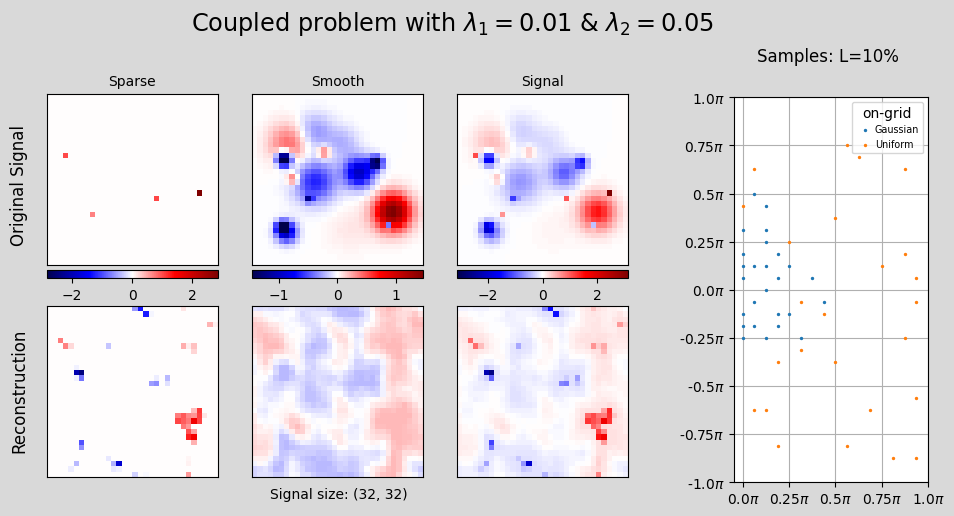

Button(description='SAVE', style=ButtonStyle())

Output()

In [22]:
sparse_rcstr, smooth_rcstr, signal_rcstr = map(
    lambda x: x.reshape(dim), (x1, x2, x1 + x2)
)

fig = plot_results(
    [sparse_signal, smooth_signal],
    [sparse_rcstr, smooth_rcstr],
    lambda1,
    lambda2,
    op,
    coupled,
)

save_widget(fig, lambda1, lambda2, op, psnr, coupled)

False

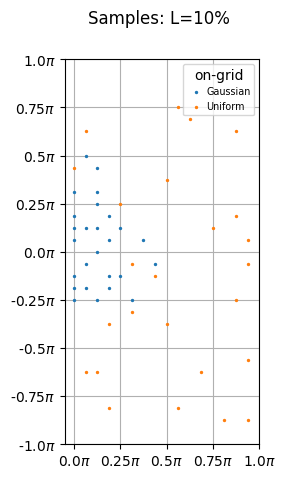

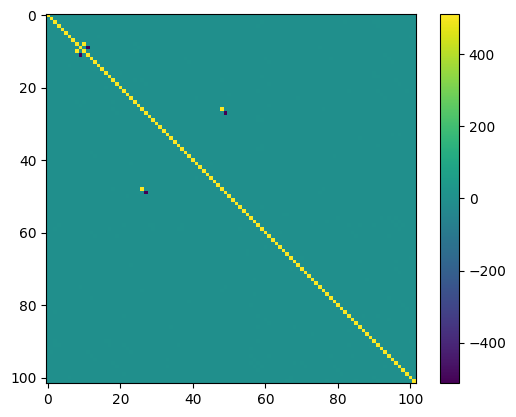

In [23]:
L = 0.1
theta = 0.5
op = NuFFT(dim, L, theta, on_grid=True, seed=seed)

op.plot_samples()
plt.figure()
plt.imshow(op.phi.cogram().asarray()) # test sans cogram() mais avec phi.apply(phi.adjoint(...vecteur aléatoire...)) + corriger demi-axe garder (0,0) + ecrire code pour découplé avec L 
plt.colorbar()
np.allclose(op.phi.cogram().asarray(), op.dim_in / 2 * np.eye(op.dim_out)) # vecteur aléatoire cogram().apply()